1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

#### olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [111]:
from io import BytesIO
import requests
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.parse import urlencode 
import datetime
import squarify # для rfm
from operator import attrgetter # для когортного анализа
import matplotlib.colors as mcolors

In [3]:
 def yd_read(public_key):
    # используем api
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  
    
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url) 
    return df

In [4]:
def todate_only(x):
    return  pd.to_datetime(pd.to_datetime(x, errors = 'ignore').dt.date, errors = 'ignore')

In [5]:
cust = yd_read('https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
orders = yd_read('https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
ord_it = yd_read('https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

In [7]:
df = orders.merge(cust, how = 'inner', on = 'customer_id')
df[['order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date']] = df[['order_purchase_timestamp', 
                                            'order_approved_at', 
                                            'order_delivered_carrier_date', 
                                            'order_delivered_customer_date', 
                                            'order_estimated_delivery_date']].apply(todate_only)
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09,2017-03-09,2017-03-10,2017-03-17,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06,2018-02-06,2018-02-07,2018-02-28,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27,2017-08-27,2017-08-28,2017-09-21,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08,2018-01-08,2018-01-12,2018-01-25,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


# *1*
 ### Сколько у нас пользователей, которые совершили покупку только один раз?
 Покупкой считаю только доставленные так, как отмены случаются и после оплата и даже после предачи в логистическую службу. В принципе данных много, не доставленных заказов в датасете около **3%**

In [8]:
df.query('order_status == "delivered"')\
            .groupby(['customer_unique_id'], as_index = False)\
            .agg({'order_id':'count'})\
            .query('order_id == 1').count()

customer_unique_id    90557
order_id              90557
dtype: int64

# 2
### Сколько в среднем в месяц не доставляют заказов?

In [9]:
df.query('order_status == "canceled"').groupby(pd.Grouper(key='order_purchase_timestamp', freq='1M')).agg({'order_status':'count'}).mean()

order_status    24.038462
dtype: float64

In [10]:
def canbool(colname):
    return np.where(colname != colname, 1, 0)

### Детализация по причина. 
### В таблице указано количество заказов в месяц с отказом на определнном этапе.

In [11]:
can = df.query('order_status == "canceled"')
can[['order_approved_at', 
     'order_delivered_carrier_date', 
     'order_delivered_customer_date']] = df[['order_approved_at', 
                                             'order_delivered_carrier_date', 
                                             'order_delivered_customer_date']].apply(canbool)

can = can.groupby(pd.Grouper(key='order_purchase_timestamp', freq='1M'))\
            .agg({'order_approved_at' : 'sum', 
                  'order_delivered_carrier_date' : 'sum', 
                  'order_delivered_customer_date' : 'sum'}).reset_index()

can.order_delivered_carrier_date = can.order_delivered_carrier_date - can.order_approved_at
can.order_delivered_customer_date = can.order_delivered_customer_date - can.order_delivered_carrier_date - can.order_approved_at
can.rename(columns = {'order_approved_at' : 'approve_pay', 
                      'order_delivered_carrier_date' : 'delivered_carrier', 
                      'order_delivered_customer_date' : 'delivery'}, inplace = True)
can

C:\Users\dmele\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,order_purchase_timestamp,approve_pay,delivered_carrier,delivery
0,2016-09-30,0,2,0
1,2016-10-31,6,13,0
2,2016-11-30,0,0,0
3,2016-12-31,0,0,0
4,2017-01-31,1,2,0
5,2017-02-28,2,15,0
6,2017-03-31,2,31,0
7,2017-04-30,4,14,0
8,2017-05-31,9,20,0
9,2017-06-30,4,12,0


#### Так например понятно, что в основном отказываются после оплаты и до передачи в логистическую службу.
#### Теперь укажем, что по средним

In [12]:
can.mean()

C:\Users\dmele\AppData\Local\Temp/ipykernel_12860/1369136637.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  can.mean()


approve_pay           5.423077
delivered_carrier    15.730769
delivery              2.653846
dtype: float64

### Есть ряд заказов со статусом "отенён", кторые при этом были доставлены. Понять причину невозможно

In [13]:
df.query('order_status == "canceled" and order_delivered_customer_date == order_delivered_customer_date')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19,2018-02-19,2018-02-20,2018-03-21,2018-03-09,6a04c8339c44b23e189446216a494569,32071,contagem,MG
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09,2016-10-09,2016-10-13,2016-10-16,2016-11-30,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07,2016-10-07,2016-10-11,2016-10-14,2016-11-29,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08,2016-10-09,2016-10-14,2016-10-19,2016-11-30,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03,2016-10-04,2016-10-25,2016-11-08,2016-11-25,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09,2016-10-10,2016-10-14,2016-11-09,2016-12-08,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC


# 3
### По каждому товару определить, в какой день недели товар чаще всего покупается

In [15]:
def to_strname_weekday(x):
    return x.strftime("%A")

In [16]:
df2 = orders.merge(ord_it, how = 'inner', on = 'order_id')
prod = df2.query('order_status == "delivered"')[['order_purchase_timestamp', 'product_id']]
prod.rename(columns = {'order_purchase_timestamp' : 'date_sell'}, inplace = True)
prod['weekday'] = pd.to_datetime(pd.to_datetime(prod.date_sell, errors = 'ignore').dt.date, errors = 'ignore').apply(to_strname_weekday)
prod

,date_sell,product_id,weekday
0,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,Monday
1,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,Tuesday
2,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,Wednesday
3,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,Saturday
4,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,Tuesday
...,...,...,...
112645,2018-02-06 12:58:58,f1d4ce8c6dd66c47bbaa8c6781c2a923,Tuesday
112646,2017-08-27 14:46:43,b80910977a37536adeddd63663f916ad,Sunday
112647,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,Monday
112648,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,Monday


In [17]:
pw = prod.groupby(['product_id', 'weekday']).agg({'date_sell':'count'}).reset_index()\
        .sort_values(['date_sell'],ascending=False).groupby(['product_id']).head(1).reset_index()

pw.rename(columns = {'date_sell' : 'all_count_in_this_weekday'}, inplace = True)
#достаём первый товар в кажой группе (сортировка в group by идёт от большего по date_sell).
pw

,index,product_id,weekday,all_count_in_this_weekday
0,15597,422879e10f46682990de24d770e7f83d,Wednesday,93
1,35751,99a4788cb24856965c36a24e339b6058,Monday,91
2,40183,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,19711,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
4,13271,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...,...
32211,23483,64123627d4116a2bc8284f1bc0a257f3,Saturday,1
32212,23491,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
32213,23493,641444946fe3a839d726c32804cd1aff,Tuesday,1
32214,23494,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1


# 4
### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [18]:
weekbuy = df.query('order_status not in ("canceled", "unavailable", "created")')[['order_purchase_timestamp', 
                                                                                  'customer_unique_id', 
                                                                                  'order_status']]
weekbuy[['order_purchase_timestamp']] = weekbuy[['order_purchase_timestamp']].apply(todate_only)
weekbuy.rename(columns = {'order_status' : 'avgcount', 'order_purchase_timestamp' : 'dateYMD'}, inplace = True)
weekbuy

,dateYMD,customer_unique_id,avgcount
0,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,delivered
1,2018-07-24,af07308b275d755c9edb36a90c618231,delivered
2,2018-08-08,3a653a41f6f9fc3d2a113cf8398680e8,delivered
3,2017-11-18,7c142cf63193a1473d2e66489a9ae977,delivered
4,2018-02-13,72632f0f9dd73dfee390c9b22eb56dd6,delivered
...,...,...,...
99436,2017-03-09,6359f309b166b0196dbf7ad2ac62bb5a,delivered
99437,2018-02-06,da62f9e57a76d978d02ab5362c509660,delivered
99438,2017-08-27,737520a9aad80b3fbbdad19b66b37b30,delivered
99439,2018-01-08,5097a5312c8b157bb7be58ae360ef43c,delivered


In [19]:
weekbuy1 = weekbuy.groupby([ 'dateYMD','customer_unique_id']).agg({'avgcount':'count'}).reset_index()\
.groupby([pd.Grouper(key='dateYMD',freq='1W'),'customer_unique_id']).agg({'avgcount':'mean'}).reset_index()\
.groupby([pd.Grouper(key='dateYMD', freq='1M'), 'customer_unique_id']).agg({'avgcount':'mean'}).reset_index()

#в первой группировке находим кто сколько и когда купил, во второй усредняем по недели, в третьей по месяцу. 
#Но по факту это количество товаров купленных за месяц. значит можно короче

weekbuy1.avgcount = weekbuy1.avgcount / (weekbuy1.dateYMD.dt.daysinmonth/7) 

#делим количество товаров купленных за месяц на количество недель в месяце

weekbuy1

,dateYMD,customer_unique_id,avgcount
0,2016-09-30,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
1,2016-09-30,b7d76e111c89f7ebf14761390f0f7d17,0.233333
2,2016-10-31,0032c76b20340da25249092a268ce66c,0.225806
3,2016-10-31,01f156677184504063bd19739f924af1,0.225806
4,2016-10-31,0313291a6f4f16df04dcf819d88c38ef,0.225806
...,...,...,...
96857,2018-09-30,f94af80b1ecdb711e74e951efdc06a76,0.233333
96858,2018-09-30,f9902ec9ad685660e7876aa9da6fb79e,0.233333
96859,2018-09-30,faa906cd93e9c6017fc5e6f885f3a05c,0.233333
96860,2018-09-30,fb7e29c65321441231990afc201c1b14,0.233333


### то же решение но короче

In [20]:
weekbuy2 = weekbuy.groupby([pd.Grouper(key='dateYMD',freq='1M'),'customer_unique_id'])\
                 .agg({'avgcount':'nunique'}).reset_index()
weekbuy2.avgcount = weekbuy2.avgcount / (weekbuy2.dateYMD.dt.daysinmonth/7) 
weekbuy2

#видно что количество строк разное это связано с тем, в какой месяц зачисляются покупки. 
#второй способ честнее считает так как понятнее куда засчитывается покупка
#Первый способ можно модернизировать, но делать я этого конечно не буду))

,dateYMD,customer_unique_id,avgcount
0,2016-09-30,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
1,2016-09-30,b7d76e111c89f7ebf14761390f0f7d17,0.233333
2,2016-10-31,0032c76b20340da25249092a268ce66c,0.225806
3,2016-10-31,01f156677184504063bd19739f924af1,0.225806
4,2016-10-31,0313291a6f4f16df04dcf819d88c38ef,0.225806
...,...,...,...
96859,2018-08-31,ffc4e1cd8aa220763480d0a18157c45d,0.225806
96860,2018-08-31,ffe204b1bb8026741b839085b2fd10f2,0.225806
96861,2018-08-31,ffec490ab531184a483efe2eedd68908,0.225806
96862,2018-08-31,fff96bc586f78b1f070da28c4977e810,0.225806


### более адекватная метрика
### среднее количество покупок у одного пользователя в неделю по месяцам

In [21]:
weekbuy.groupby(['customer_unique_id', 'dateYMD']).agg({'avgcount':'count'}).reset_index()\
    .groupby(pd.Grouper(key='dateYMD',freq='1W')).agg({'avgcount':'mean'}).reset_index().fillna(0)\
    .groupby(pd.Grouper(key='dateYMD',freq='1M')).agg({'avgcount':'mean'}).reset_index()

,dateYMD,avgcount
0,2016-09-30,0.500000
1,2016-10-31,0.406340
2,2016-11-30,0.000000
3,2016-12-31,0.250000
4,2017-01-31,0.911285
5,2017-02-28,1.012622
6,2017-03-31,1.014317
7,2017-04-30,1.009852
8,2017-05-31,1.014667
9,2017-06-30,1.015073


# 5 
### Когортный анализ пользователей. 
#### В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.retention = количество пользователей когорты сделавших покупку в течение третьего месяца после первой покупки / количество пользователей в когорте 

In [41]:
cohort_df = df.query('order_status == "delivered"')[['customer_unique_id', 'order_purchase_timestamp', 'order_id']]
cohort_df.rename(columns = {'order_id' : 'InvoiceNo', 
                             'order_purchase_timestamp' : 'InvoiceDate',
                             'customer_unique_id' : 'CustomerID'}, inplace = True)
cohort_df

,CustomerID,InvoiceDate,InvoiceNo
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,e481f51cbdc54678b7cc49136f2d6af7
1,af07308b275d755c9edb36a90c618231,2018-07-24,53cdb2fc8bc7dce0b6741e2150273451
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,47770eb9100c2d0c44946d9cf07ec65d
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18,949d5b44dbf5de918fe9c16f97b45f8a
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,ad21c59c0840e6cb83a9ceb5573f8159
...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09,9c5dedf39a927c1b2549525ed64a053c
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06,63943bddc261676b46f01ca7ac2f7bd8
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27,83c1379a015df1e13d02aae0204711ab
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08,11c177c8e97725db2631073c19f07b62


In [74]:
# создаем переменные cohort(когорту на основе даты первой покупки) и order_month (месяц даты покупки)
cohort_df['order_month'] = cohort_df['InvoiceDate'].dt.to_period('M')
cohort_df['cohort'] = cohort_df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 
cohort_df.query('CustomerID == "1b6c7548a2a1f9037c1fd3ddfed95f33"') # ПРОВЕРИЛИ

,CustomerID,InvoiceDate,InvoiceNo,order_month,cohort
8030,1b6c7548a2a1f9037c1fd3ddfed95f33,2018-02-14,43f08913407cac4e74a898d968e58c1a,2018-02,2017-11
22630,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-12-05,bba17d97a5a45416d0782d5d07fe740d,2017-12,2017-11
24840,1b6c7548a2a1f9037c1fd3ddfed95f33,2018-01-25,75b71f40b3c71469d12c7e4dc2ce0794,2018-01,2017-11
53420,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-24,54f334d6a9d60b69dae5409327f73645,2017-11,2017-11
65530,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-12-04,a8347ba04591f966205182a1c99c310e,2017-12,2017-11
75390,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13,abbd44be67f3cad08ffac14daf36af60,2017-11,2017-11
83570,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-12-20,ab6d1b0b8360c208b62852f53726f0e6,2017-12,2017-11


In [99]:
# агрегируем данные по cohortи order_monthи подсчитываем количество уникальных клиентов в каждой группе. 
#Дополнительно добавляем period_number, указывающее количество прошедших месяцев со дня первой покупки
cohort = cohort_df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
cohort['period_number'] = (cohort.order_month - cohort.cohort).apply(attrgetter('n')) #применяю какуюто штуку, которую нашёл
cohort.head(20) # таблица показывает, что в окт. 2016 делали покупки 262 чел. и только 10 покупали в другие месяцы

,cohort,order_month,n_customers,period_number
0,2016-09,2016-09,1,0
1,2016-10,2016-10,262,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11
5,2016-10,2017-11,1,13
6,2016-10,2018-01,1,15
7,2016-10,2018-03,1,17
8,2016-10,2018-05,2,19
9,2016-10,2018-06,2,20


In [104]:
# Делаем сводную таблицу. 
# Каждая строка содержит информацию о когорте, а каждый столбец содержит значения за определенный период.
cohort_pivot = cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot
# Выгядит почти как ответ

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN,NaN
2017-04,2256.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN


In [177]:
# Чтобы получить матрицу удержаниe, нужно 
# разделить значения каждой строки на первое значение строки, которое на самом деле является размером когорты
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix
# уже здесь можно сказать, что лучше когортой оказалась когорта 2017-06

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


In [178]:
cohort_size

cohort
2016-09       1.0
2016-10     262.0
2016-12       1.0
2017-01     717.0
2017-02    1628.0
2017-03    2503.0
2017-04    2256.0
2017-05    3451.0
2017-06    3037.0
2017-07    3752.0
2017-08    4057.0
2017-09    4004.0
2017-10    4328.0
2017-11    7060.0
2017-12    5338.0
2018-01    6842.0
2018-02    6288.0
2018-03    6774.0
2018-04    6582.0
2018-05    6506.0
2018-06    5878.0
2018-07    5949.0
2018-08    6144.0
Freq: M, Name: 0, dtype: float64

In [163]:
# до янв 2017 поведение пользователей не очень адекваное да и размеры когорт несопоставимы
# по хорошему и янв надо выкинуть
# последние 3 когорты можно выкинуть, так как данных через 3 месяца после по ним нет
# в итоге оставляем:
retention_matrix = retention_matrix.loc[(retention_matrix.index > '2017-01') & (retention_matrix.index < '2018-06')].round(4)
cohort_size = cohort_size.loc[(cohort_size.index > '2017-01') & (cohort_size.index < '2018-06')]

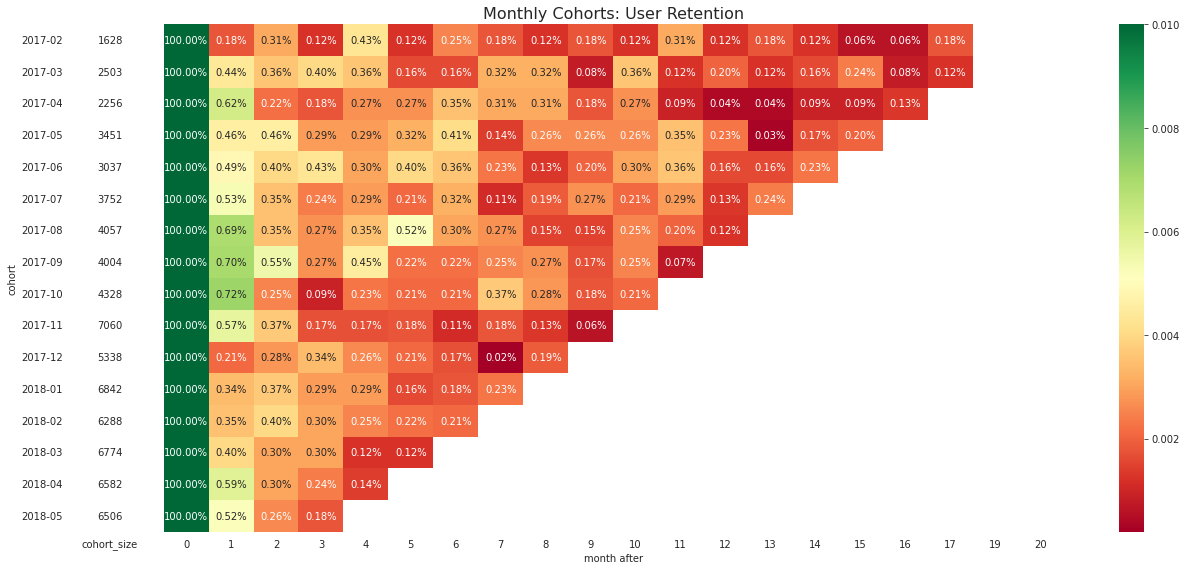

In [175]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'width_ratios': [1, 14]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                cmap='RdYlGn',
                vmax = 0.01,
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='month after',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()


### Визуализацию брал из гайда и только подкрутил под себя
#### если ограничить с января по декабрь 2017 года то получится ответ такой же: июнь 2017

# 6
### RFM-анализ

In [53]:

alldf = ord_it.merge(df, how = 'left', on = 'order_id')
rfm_orders = alldf.query('order_status == "delivered"')\
           .drop(columns = ['customer_id', 'customer_zip_code_prefix', 'customer_city', 'order_status', 
                            'customer_state', 'order_approved_at', 'order_delivered_carrier_date',
                            'order_delivered_customer_date', 'order_estimated_delivery_date', 'product_id',
                            'order_item_id', 'seller_id', 'shipping_limit_date', 'freight_value'])
rfm_orders.rename(columns = {'order_id' : 'InvoiceNo', 
                             'order_purchase_timestamp' : 'InvoiceDate',
                             'customer_unique_id' : 'CustomerID',
                             'price' : 'Price'}, inplace = True)
rfm_orders

,InvoiceNo,Price,InvoiceDate,CustomerID
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,2017-09-13,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,239.90,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,199.00,2018-01-14,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,12.99,2018-08-08,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5
...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,299.99,2018-04-23,0c9aeda10a71f369396d0c04dce13a64
112646,fffcd46ef2263f404302a634eb57f7eb,350.00,2018-07-14,0da9fe112eae0c74d3ba1fe16de0988b
112647,fffce4705a9662cd70adb13d4a31832d,99.90,2017-10-23,cd79b407828f02fdbba457111c38e4c4
112648,fffe18544ffabc95dfada21779c9644f,55.99,2017-08-14,eb803377c9315b564bdedad672039306


In [54]:
rfm_orders = rfm_orders.groupby(['InvoiceDate', 'CustomerID']).agg({'Price': lambda x: x.sum()}).reset_index()
rfm_orders

,InvoiceDate,CustomerID,Price
0,2016-09-15,830d5b7aaa3b6f1e9ad63703bec97d23,134.97
1,2016-10-03,10e89fd8e5c745f81bec101207ba4d7d,74.90
2,2016-10-03,2f64e403852e6893ae37485d5fcacdaf,21.90
3,2016-10-03,32ea3bdedab835c3aa6cb68ce66565ef,29.90
4,2016-10-03,61db744d2f835035a5625b59350c6b63,36.49
...,...,...,...
95583,2018-08-29,7febafa06d9d8f232a900a2937f04338,45.90
95584,2018-08-29,afbcfd0b9c5233e7ccc73428526fbb52,457.75
95585,2018-08-29,b4dcade04bc548b7e3b0243c801f8c26,99.00
95586,2018-08-29,b701bebbdf478f5500348f03aff62121,24.90


In [55]:
# Сейчас - дата последней покупки в базе. Будем считать что в этот день сделали анализ

now = rfm_orders['InvoiceDate'].max() + datetime.timedelta(days=1)
now

Timestamp('2018-08-30 00:00:00')

In [57]:
rfm_orders['DaysSinceOrder'] = rfm_orders['InvoiceDate'].apply(lambda x: (now - x).days)
rfm_orders

,InvoiceDate,CustomerID,Price,DaysSinceOrder
0,2016-09-15,830d5b7aaa3b6f1e9ad63703bec97d23,134.97,714
1,2016-10-03,10e89fd8e5c745f81bec101207ba4d7d,74.90,696
2,2016-10-03,2f64e403852e6893ae37485d5fcacdaf,21.90,696
3,2016-10-03,32ea3bdedab835c3aa6cb68ce66565ef,29.90,696
4,2016-10-03,61db744d2f835035a5625b59350c6b63,36.49,696
...,...,...,...,...
95583,2018-08-29,7febafa06d9d8f232a900a2937f04338,45.90,1
95584,2018-08-29,afbcfd0b9c5233e7ccc73428526fbb52,457.75,1
95585,2018-08-29,b4dcade04bc548b7e3b0243c801f8c26,99.00,1
95586,2018-08-29,b701bebbdf478f5500348f03aff62121,24.90,1


In [58]:
period = (rfm_orders.InvoiceDate.max() - rfm_orders.InvoiceDate.min()).days

In [60]:
rfm = rfm_orders.groupby('CustomerID').agg({
    'DaysSinceOrder': lambda x: x.min(),
    'InvoiceDate': lambda x: len([d for d in x if d >= now - datetime.timedelta(days=period+1)])}).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm

,CustomerID,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1
2,0000f46a3911fa3c0805444483337064,538,1
3,0000f6ccb0745a6a4b88665a16c9f078,322,1
4,0004aac84e0df4da2b147fca70cf8255,289,1
...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,448,1
93354,fffea47cd6d3cc0a88bd621562a9d061,263,1
93355,ffff371b4d645b6ecea244b27531430a,569,1
93356,ffff5962728ec6157033ef9805bacc48,120,1


### таблица готова, количество строк в ней именно такое какое нужно, значит ничего не потеряли.
### количество пользователей определяем как количество уникальных пользователей совершивших заказ и получивших его

In [61]:
rfm = rfm.merge(rfm_orders.groupby('CustomerID').agg({'Price':'sum'}).reset_index(), how = 'left', on = 'CustomerID')
rfm.rename(columns={'Price': 'Monetary'}, inplace=True)
rfm

,CustomerID,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,538,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00
...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,1570.00
93354,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89
93355,ffff371b4d645b6ecea244b27531430a,569,1,89.90
93356,ffff5962728ec6157033ef9805bacc48,120,1,115.00


In [62]:
#квантили понятная и удобная вещь не привязанная к кокретным занченям, вычислим их для нашей выборки
quintiles = rfm[['Recency',  'Monetary', 'Frequency']].quantile([.2, .4, .6, .8]).to_dict()
quintiles
#для частоты квантили не подходят

{'Recency': {0.2: 93.0, 0.4: 178.0, 0.6: 269.0, 0.8: 383.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0}}

<AxesSubplot:>

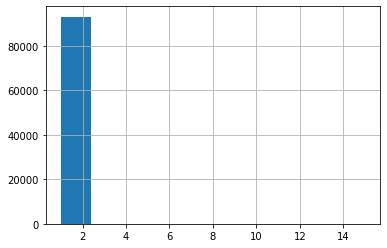

In [63]:
#посмотрим что там за распределение
rfm.Frequency.hist()
#да, невероятно много человек сделали единственный заказ...

<AxesSubplot:>

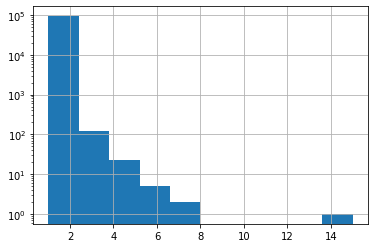

In [64]:
# если линейная шкала не подошла, всегда используем логарифмическую
plt.yscale('log')
rfm.Frequency.hist()
#Так на много лучшею. будем разбивать на когорты исходя из этого графика

In [65]:
#но не будем делать это вручную!!!
quintiles.update({'Frequency' : np.log(rfm.Frequency.value_counts()).quantile([.2, .4, .6, .8]).round(0).to_dict()})
quintiles
#выглядит очень хорошо

{'Recency': {0.2: 93.0, 0.4: 178.0, 0.6: 269.0, 0.8: 383.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0}}

In [184]:
np.log(rfm.Frequency.value_counts()).quantile([.2, .4, .6, .8]).round(0)

0.2    1.0
0.4    2.0
0.6    3.0
0.8    6.0
Name: Frequency, dtype: float64

In [183]:
rfm.Frequency.value_counts()


1     91343
2      1864
3       120
4        17
5         6
6         5
7         2
15        1
Name: Frequency, dtype: int64

In [66]:
def r_score(x, metrics_name):
    if x <= quintiles[metrics_name][.2]:
        return 5
    elif x <= quintiles[metrics_name][.4]:
        return 4
    elif x <= quintiles[metrics_name][.6]:
        return 3
    elif x <= quintiles[metrics_name][.8]:
        return 2
    else:
        return 1

def fm_score(x, metrics_name):
    if x <= quintiles[metrics_name][.2]:
        return 1
    elif x <= quintiles[metrics_name][.4]:
        return 2
    elif x <= quintiles[metrics_name][.6]:
        return 3
    elif x <= quintiles[metrics_name][.8]:
        return 4
    else:
        return 5    

In [67]:
#сказано - сделано. По факту всё готово для визуализации.
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x, 'Recency'))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [68]:
segt_map = {
    '[1-2][1-2]': 'hibernating',
    '[1-2][3-4]': 'at risk',
    '[1-2]5': 'can\'t loose',
    '3[1-2]': 'about to sleep',
    '33': 'need attention',
    '[3-4][4-5]': 'loyal customers',
    '41': 'promising',
    '51': 'new customers',
    '[4-5][2-3]': 'potential loyalists',
    '5[4-5]': 'champions'
}
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,promising
2,0000f46a3911fa3c0805444483337064,538,1,69.00,1,1,2,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,2,1,1,hibernating
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,2,1,5,hibernating
...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,1570.00,1,1,5,hibernating
93354,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89,3,1,2,about to sleep
93355,ffff371b4d645b6ecea244b27531430a,569,1,89.90,1,1,3,hibernating
93356,ffff5962728ec6157033ef9805bacc48,120,1,115.00,4,1,4,promising


In [1]:
#немного визуализации 
df = px.data.tips()
fig = px.histogram(rfm, x="Segment", nbins=20, log_y=True)
fig.show()
#количество пользователей в каждой группе в логарифмическом масштабе

NameError: name 'px' is not defined

In [70]:
rfmAGG = rfm.groupby(['Segment']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
rfmAGG.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfmAGG = rfmAGG.reset_index()
rfmAGG

,Segment,RecencyMean,FrequencyMean,MonetaryMean,Count
0,about to sleep,221.6,1.0,133.6,18703
1,at risk,338.6,3.1,405.4,30
2,champions,50.4,5.5,791.9,14
3,hibernating,396.1,1.0,142.3,37046
4,loyal customers,163.8,4.8,641.8,15
5,need attention,227.7,3.0,477.2,14
6,new customers,46.2,1.0,138.9,18239
7,potential loyalists,88.3,2.1,266.0,1046
8,promising,136.7,1.0,142.6,18251


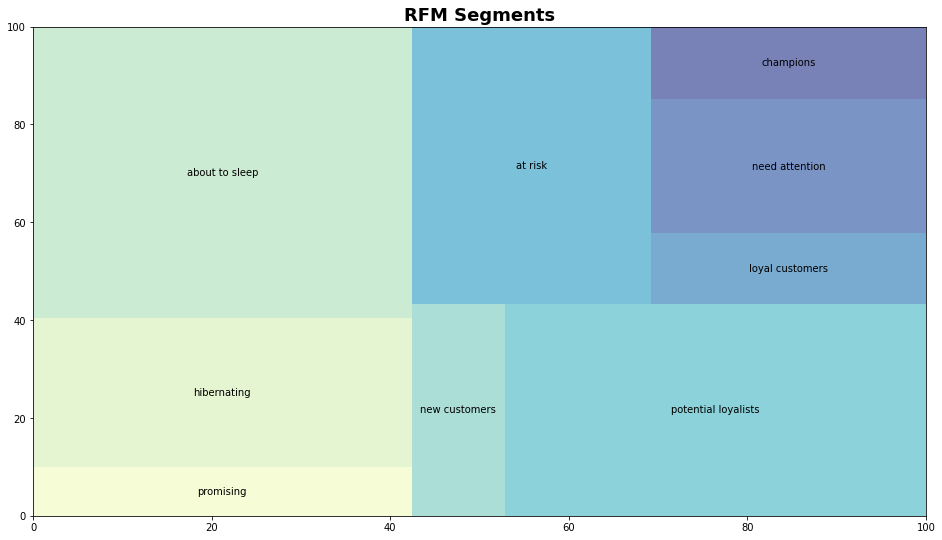

In [71]:
#попытка построить древовидную карту
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfmAGG['MonetaryMean'], 
              label=['promising', 'hibernating', 'about to sleep', 
                     'new customers', 'potential loyalists', 'at risk', 
                     'loyal customers', 'need attention', 'champions'], alpha=.6, color=sns.color_palette("YlGnBu", len(rfmAGG.Segment)))
plt.title("RFM Segments",fontsize=18,fontweight="bold")
#plt.axis('off')
plt.show()
#построена, но мне не понятно по какому принципу делаются квадраты promising и hibernating имею равное значение MonetaryMean, а на карте они разные

In [ ]:
#для проверки строк

In [51]:
alldf.query('customer_unique_id == "830d5b7aaa3b6f1e9ad63703bec97d23"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15,2016-11-07,2016-11-09,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15,2016-11-07,2016-11-09,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15,2016-11-07,2016-11-09,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP


In [50]:
alldf.groupby('customer_unique_id').agg({'order_id' : 'nunique'}).reset_index().query('customer_unique_id == "4546caea018ad8c692964e3382debd19"')

,customer_unique_id,order_id
25885,4546caea018ad8c692964e3382debd19,1


In [ ]:
alldf.query('order_id == "8272b63d03f5f79c56e9e4120aec44ef"')